In [4]:
%pip install kaggle opencv-python seaborn tensorflow numpy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Imports
import numpy as np
import pandas as pd

import json
import random

import os
from PIL import Image

import matplotlib.pyplot as plt

from tensorflow import keras as K
import tensorflow as tf

## Carga del Dataset


In [6]:
DS_PATH = "ds"
DS_ENTRY = f"{DS_PATH}/Poses.json"

# Download if folder was not present
if not os.path.exists(DS_PATH):
    os.system(
        f"kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset -p {DS_PATH} --unzip"
    )

with open(DS_ENTRY, "r") as file:
    data = json.load(file)

df = pd.DataFrame(data["Poses"])

df.head()

,id,sanskrit_name,english_name,img_url
0,1,Navasana,Boat,https://www.dropbox.com/s/4m64ztxkj8a4dab/boat...
1,2,Ardha Navasana,Half-Boat,https://www.dropbox.com/s/1nx0r94msxjwvyp/boat...
2,3,Dhanurasana,Bow,https://www.dropbox.com/s/wizj5kwxvez4c0a/bow....
3,4,Setu Bandha Sarvangasana,Bridge,https://www.dropbox.com/s/f1w64ybg4sn8ejt/brid...
4,5,Baddha Konasana,Butterfly,https://www.dropbox.com/s/3h2pts6xbn28dh7/butt...


In [7]:
def resize_and_pad_image(image, img_size):
    if image.mode in ("RGBA", "LA"):
        # Create a white background image (255, 255, 255 = white)
        white_background = Image.new("RGB", image.size, (255, 255, 255))
        # Paste the image onto the white background, using the alpha channel as a mask
        white_background.paste(image.convert("RGB"), mask=image.split()[-1])
        image = white_background  # Update image to have white background

    original_width, original_height = image.size
    aspect_ratio = original_width / original_height

    # Calculate new dimensions based on aspect ratio
    if original_width > original_height:
        new_width = img_size[0]
        new_height = int(img_size[0] / aspect_ratio)
    else:
        new_height = img_size[1]
        new_width = int(img_size[1] * aspect_ratio)

    # Resize the image with high-quality downsampling
    resized_image = image.resize((new_width, new_height), Image.LANCZOS)

    # Create a new blank image with the target size (white padding)
    padded_image = Image.new("RGB", img_size, (255, 255, 255))

    # Calculate position to paste the resized image onto the padded image
    x_offset = (img_size[0] - resized_image.size[0]) // 2
    y_offset = (img_size[1] - resized_image.size[1]) // 2

    # Paste the resized image onto the padded image
    padded_image.paste(resized_image, (x_offset, y_offset))

    return padded_image

In [8]:
# import cv2
from pathlib import Path

valid_img_extensions = [".jpg", ".jpeg", ".png", ".bmp"]

# Resolucion de imagenes de 128 x 128
img_res = 128

X = []
y = []
labelNames = {}

print("[INFO]: Leyendo imagenes de poses")
for id, pose in enumerate(df.itertuples()):
    print(f"[INFO]: Procesando pose: {pose.sanskrit_name} / {pose.english_name}")
    labelNames[id] = pose.english_name

    # Obtengo la carpeta de imagenes de la pose
    folder = f"{DS_PATH}/{pose.sanskrit_name}"

    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)

        if Path(img_path).suffix.lower() not in valid_img_extensions:
            print(f"[WARN]: Formato {img_path} no valido")
            continue

        img = K.utils.load_img(img_path)

        img = resize_and_pad_image(img, (img_res, img_res))

        X.append(img)
        y.append(id)


# Convertir a numpy array
X = np.array(X)
y = np.array(y)

[INFO]: Leyendo imagenes de poses
[INFO]: Procesando pose: Navasana / Boat
[INFO]: Procesando pose: Ardha Navasana / Half-Boat
[INFO]: Procesando pose: Dhanurasana / Bow


[INFO]: Procesando pose: Setu Bandha Sarvangasana / Bridge
[INFO]: Procesando pose: Baddha Konasana / Butterfly
[INFO]: Procesando pose: Ustrasana / Camel
[INFO]: Procesando pose: Marjaryasana / Cat
[INFO]: Procesando pose: Bitilasana / Cow
[INFO]: Procesando pose: Utkatasana / Chair
[INFO]: Procesando pose: Balasana / Child's Pose


/home/emasuriano/miniconda3/envs/myenv/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[INFO]: Procesando pose: Sivasana / Corpse
[INFO]: Procesando pose: Alanasana / Crescent Lunge
[INFO]: Procesando pose: Bakasana / Crow
[INFO]: Procesando pose: Ardha Pincha Mayurasana / Dolphin
[INFO]: Procesando pose: Adho Mukha Svanasana / Downward-Facing Dog
[INFO]: Procesando pose: Garudasana / Eagle
[INFO]: Procesando pose: Utthita Hasta Padangusthasana / Extended Hand to Toe
[INFO]: Procesando pose: Utthita Parsvakonasana / Extended Side Angle
[INFO]: Procesando pose: Pincha Mayurasana / Forearm Stand
[INFO]: Procesando pose: Uttanasana / Forward Bend with Shoulder Opener
[INFO]: Procesando pose: Ardha Chandrasana / Half-Moon
[INFO]: Procesando pose: Adho Mukha Vrksasana / Handstand
[INFO]: Procesando pose: Anjaneyasana / Low Lunge
[INFO]: Procesando pose: Supta Kapotasana / Pigeon
[INFO]: Procesando pose: Eka Pada Rajakapotasana / King Pigeon
[INFO]: Procesando pose: Phalakasana / Plank
[INFO]: Procesando pose: Halasana / Plow
[INFO]: Procesando pose: Parsvottanasana / Pyramid


## Sample Preview

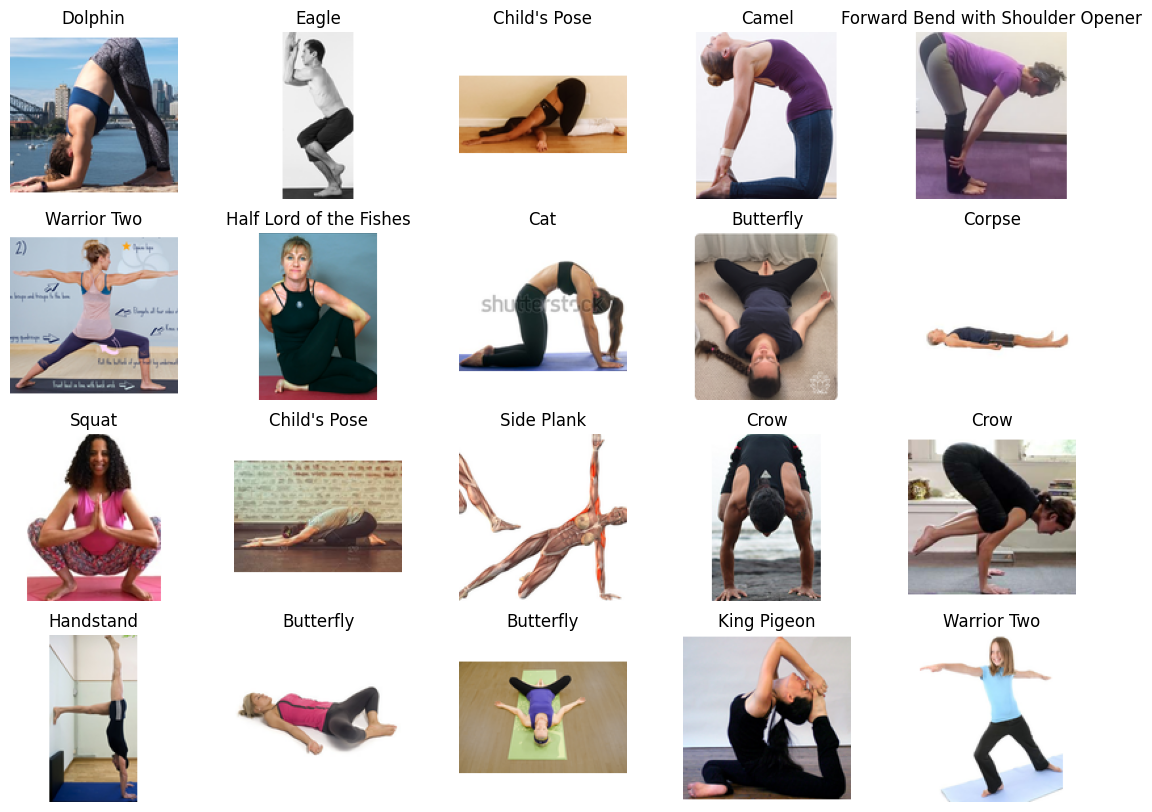

In [9]:
fig = plt.figure(figsize=(14, 10))

samples = np.random.randint(0, len(X), 20)

for i, img_idx in enumerate(samples):
    fig.add_subplot(4, 5, i + 1)

    plt.imshow(X[img_idx])
    plt.title(labelNames[y[img_idx]])
    plt.axis("off")

plt.show()

## Analisis de la distribucion

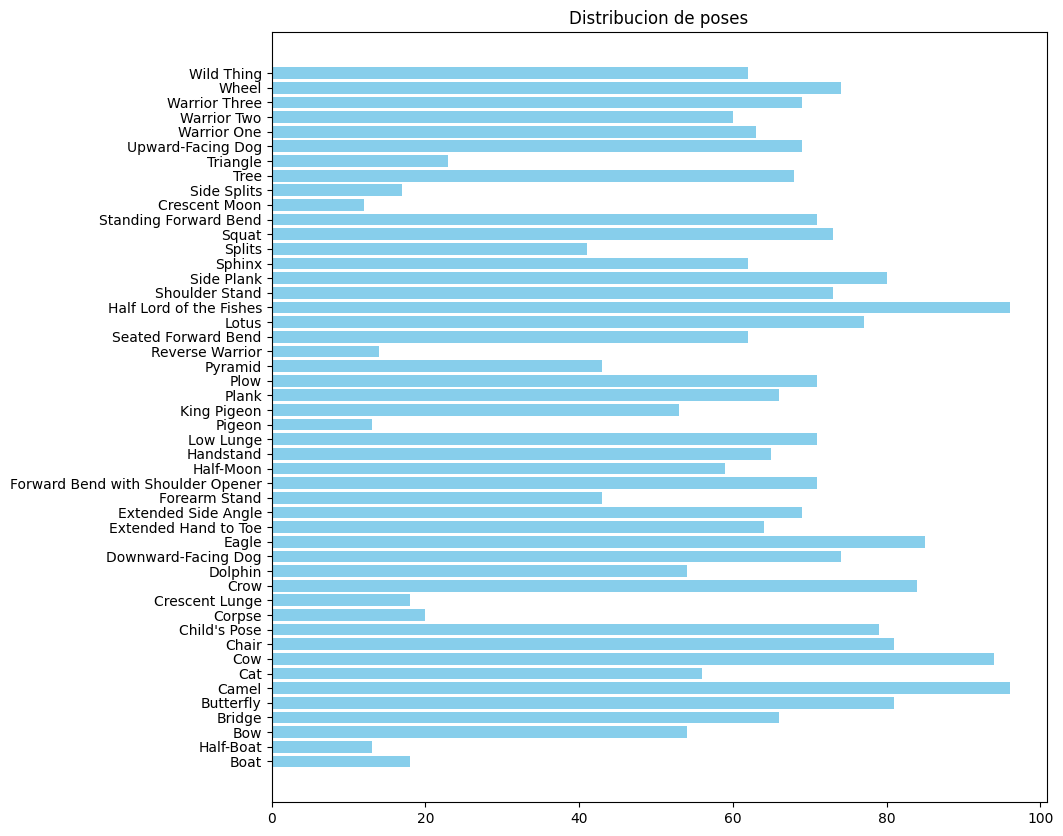

In [10]:
y_counts = np.bincount(y)

plt.figure(figsize=(10, 10))
plt.barh(labelNames.values(), y_counts, color="skyblue")
plt.title("Distribucion de poses")
plt.show()

## Balanceo de clases - Oversampling

In [11]:
# ImageDataGenerator for oversampling
datagen = K.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)


def oversample_imgs(imgs, amount):
    oversamples = []

    for _ in range(amount):
        image = imgs[np.random.randint(len(imgs))]
        new_img = datagen.random_transform(image)
        oversamples.append(new_img)

    return oversamples


target_count = np.max(y_counts)

for label in np.unique(y):
    X_filtered = X[y == label]
    num_augmentations = target_count - len(X_filtered)

    if num_augmentations > 0:
        print(f"[INFO]: Nuevas {num_augmentations} poses de {labelNames[label]}")
        img_random_order = np.random.permutation(X_filtered)

        X_aug = np.array(
            [
                datagen.random_transform(img_random_order[i % len(X_filtered)])
                for i in range(num_augmentations)
            ]
        )
        y_aug = np.array([label] * num_augmentations)

        X = np.append(X, X_aug, axis=0)
        y = np.append(y, y_aug, axis=0)

[INFO]: Nuevas 78 poses de Boat
[INFO]: Nuevas 83 poses de Half-Boat
[INFO]: Nuevas 42 poses de Bow
[INFO]: Nuevas 30 poses de Bridge
[INFO]: Nuevas 15 poses de Butterfly
[INFO]: Nuevas 40 poses de Cat
[INFO]: Nuevas 2 poses de Cow
[INFO]: Nuevas 15 poses de Chair
[INFO]: Nuevas 17 poses de Child's Pose
[INFO]: Nuevas 76 poses de Corpse
[INFO]: Nuevas 78 poses de Crescent Lunge
[INFO]: Nuevas 12 poses de Crow
[INFO]: Nuevas 42 poses de Dolphin
[INFO]: Nuevas 22 poses de Downward-Facing Dog
[INFO]: Nuevas 11 poses de Eagle
[INFO]: Nuevas 32 poses de Extended Hand to Toe
[INFO]: Nuevas 27 poses de Extended Side Angle
[INFO]: Nuevas 53 poses de Forearm Stand
[INFO]: Nuevas 25 poses de Forward Bend with Shoulder Opener
[INFO]: Nuevas 37 poses de Half-Moon
[INFO]: Nuevas 31 poses de Handstand
[INFO]: Nuevas 25 poses de Low Lunge
[INFO]: Nuevas 83 poses de Pigeon
[INFO]: Nuevas 43 poses de King Pigeon
[INFO]: Nuevas 30 poses de Plank
[INFO]: Nuevas 25 poses de Plow
[INFO]: Nuevas 53 poses de

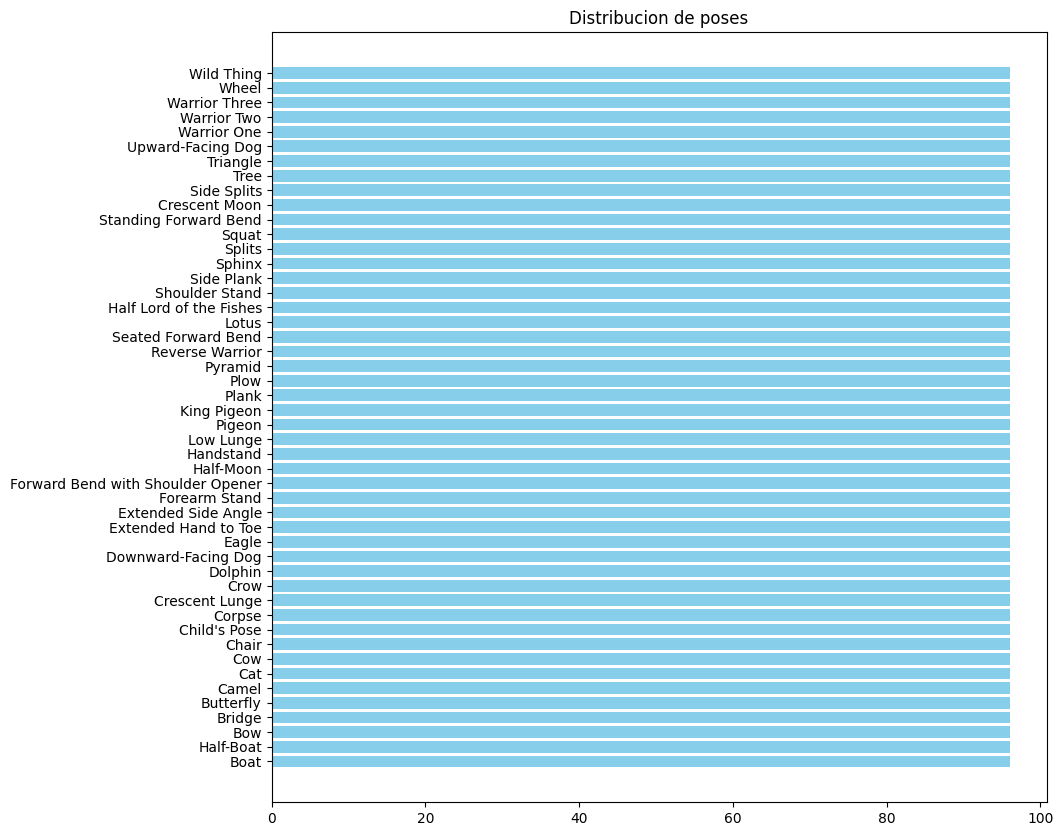

In [12]:
y_counts = np.bincount(y)

plt.figure(figsize=(10, 10))
plt.barh(labelNames.values(), y_counts, color="skyblue")
plt.title("Distribucion de poses")
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Output the results
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# Check the class distribution
print("Class distribution in y_train:", np.bincount(y_train))
print("Class distribution in y_test:", np.bincount(y_test))

X_train: (3225, 128, 128, 3)
y_train: (3225,)
X_test: (1383, 128, 128, 3)
y_test: (1383,)
Class distribution in y_train: [67 67 67 67 68 67 67 67 67 67 67 67 68 67 67 67 67 67 67 68 67 67 67 67
 68 67 68 68 67 67 67 67 67 67 67 67 67 68 67 67 68 67 67 68 67 67 67 67]
Class distribution in y_test: [29 29 29 29 28 29 29 29 29 29 29 29 28 29 29 29 29 29 29 28 29 29 29 29
 28 29 28 28 29 29 29 29 29 29 29 29 29 28 29 29 28 29 29 28 29 29 29 29]


## Normalization

In [14]:
from sklearn.preprocessing import LabelBinarizer

# Img normalization
X_train_n = X_train / 255
X_test_n = X_test / 255

# One hot encoding for labels
lb = LabelBinarizer()
y_train_n = lb.fit_transform(y_train)
y_test_n = lb.transform(y_test)

## Data Augmentation

In [15]:
datagen = K.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,  # Zoom in/out by up to 10%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode="nearest",  # Fill mode to avoid clipping of images (reflect, wrap, constant)
    validation_split=0.3,
)

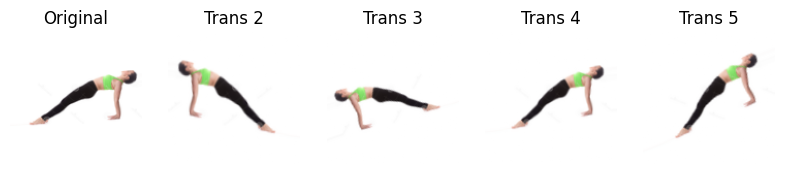

In [16]:
sample = random.randint(0, len(X_train_n))

img_orig = X_train_n[sample]

fig = plt.figure(figsize=(16, 10))

fig.add_subplot(4, 8, 1)
plt.imshow(img_orig)
plt.title("Original")
plt.axis("off")

# # Show transformations
# fig = plt.figure(figsize=(8, 8))
for n in range(2, 6):
    fig.add_subplot(4, 8, n)
    img = datagen.random_transform(img_orig)

    plt.imshow(img)
    plt.title(f"Trans {n}")
    plt.axis("off")

plt.show()

## Model definition

> Reemplazar esto por el modelo que quieran entrenar! ⚠️ 

Este es un ejemplo de un modelo pre-entrenado en modo forward (no hay capas adicionales).

In [24]:
input_shape = (img_res, img_res, 3)

# Pre-trained
base_model = K.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape,
)

# transfer-learning mode
base_model.trainable = False

# Entry layer
model = K.models.Sequential()
model.add(K.layers.Input(shape=input_shape))

# Add base model
model.add(base_model)
model.add(K.layers.GlobalAveragePooling2D())

# Example of hidden layer
model.add(
    K.layers.Dense(
        128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )
)
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dropout(0.5))

model.add(
    K.layers.Dense(
        64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )
)
model.add(K.layers.BatchNormalization())

# Output
model.add(K.layers.Dense(len(labelNames), activation="softmax"))

model.compile(
    loss="categorical_crossentropy",
    optimizer=K.optimizers.Adam(
        learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08
    ),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [25]:
# Early stopping in case it stops converging
early_stopping = K.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    mode="min",
    restore_best_weights=True,
)

# Use datageneration for training and validation data
train_data = datagen.flow(X_train_n, y_train_n, batch_size=64, subset="training")
validation_data = datagen.flow(X_train_n, y_train_n, batch_size=64, subset="validation")


# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=200,
    callbacks=[early_stopping],
)

[INFO]: Entrenando la red...
Epoch 1/200
36/36 [==============================] - 8s 161ms/step - loss: 4.5119 - accuracy: 0.0341 - val_loss: 4.1320 - val_accuracy: 0.0269
Epoch 2/200
36/36 [==============================] - 5s 150ms/step - loss: 4.0884 - accuracy: 0.0660 - val_loss: 4.0435 - val_accuracy: 0.0558
Epoch 3/200
36/36 [==============================] - 5s 146ms/step - loss: 3.7867 - accuracy: 0.1014 - val_loss: 3.9570 - val_accuracy: 0.1055
Epoch 4/200
36/36 [==============================] - 5s 149ms/step - loss: 3.5477 - accuracy: 0.1519 - val_loss: 3.8209 - val_accuracy: 0.1313
Epoch 5/200
36/36 [==============================] - 5s 150ms/step - loss: 3.3727 - accuracy: 0.1718 - val_loss: 3.7015 - val_accuracy: 0.1613
Epoch 6/200
36/36 [==============================] - 5s 148ms/step - loss: 3.1961 - accuracy: 0.2170 - val_loss: 3.5441 - val_accuracy: 0.2068
Epoch 7/200
36/36 [==============================] - 5s 150ms/step - loss: 3.0597 - accuracy: 0.2383 - val_loss: 

In [26]:
from sklearn.metrics import classification_report

print("[INFO]: Evaluando el modelo...")
predictions = model.predict(X_test_n, batch_size=64)

print(
    classification_report(
        y_test,
        predictions.argmax(axis=1),
        target_names=labelNames.values(),
    )
)

[INFO]: Evaluando el modelo...


2024-10-25 12:00:37.860557: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 271908864 exceeds 10% of free system memory.


22/22 [==============================] - 1s 39ms/step
                                   precision    recall  f1-score   support

                             Boat       0.94      1.00      0.97        29
                        Half-Boat       0.89      0.86      0.88        29
                              Bow       0.96      0.76      0.85        29
                           Bridge       0.85      0.76      0.80        29
                        Butterfly       0.58      0.68      0.62        28
                            Camel       0.93      0.86      0.89        29
                              Cat       0.65      0.69      0.67        29
                              Cow       0.72      0.72      0.72        29
                            Chair       0.76      0.90      0.83        29
                     Child's Pose       0.57      0.86      0.68        29
                           Corpse       1.00      0.86      0.93        29
                   Crescent Lunge       0.81 

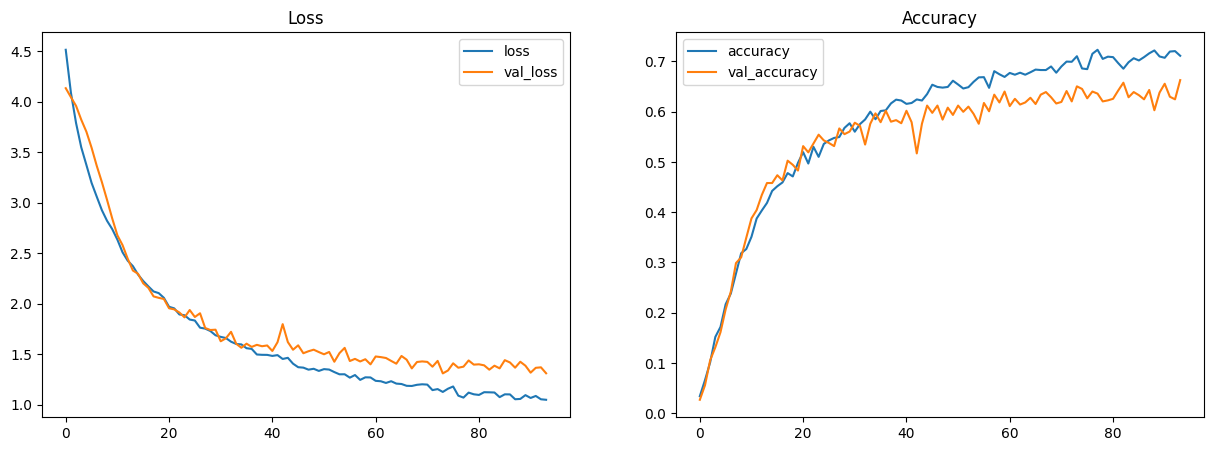

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(H.history)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot 1: Loss and Validation Loss on the first subplot
history_df.loc[:, ["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Loss")

# Plot 2: Accuracy and Validation Accuracy on the second subplot
history_df.loc[:, ["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Accuracy")

plt.show()